The use of a Recommendation system is to provide users with recommendations based on their search preferences. In this task, I will introduce you to a machine learning project on the Netflix recommendation system with Python.

### Netflix Recommendation System
Netflix is a company that manages a large collection of TV shows and movies, streaming it anytime via online. This business is profitable because users make a monthly payment to access the platform. However, customers can cancel their subscriptions at any time.

Therefore, the company must keep the users hooked on the platform and not lose their interest. This is where recommendation systems start to play an important role, providing valuable suggestions to users is essential.

Netflix’s recommendation system helps them increase their popularity among service providers as they help increase number of items sold, offer a diverse selection of items, increase user satisfaction, as well as user loyalty to the company, and they are very helpful in getting a better understanding of what the user wants. Then it’s easier to get the user to make better decisions from a wide variety of movie products.

The idea behind the Netflix recommendation system is to recommend the most popular movies to users. They could be the most-watched, or also the ones with the highest ratings. The popularity of recommendations can be built based on usage data and article content.

### Netflix Recommendation System with Python
In this section, I will take you through a Machine Learning project on Netflix Recommendation System with Python. I will start by importing all the python libraries and the dataset:

In [6]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
sns.set_style("darkgrid")
# Skip date
df1 = pd.read_csv('E:/Netflix Recommendation System with Python/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1['Rating'] = df1['Rating'].astype(float)
df = df1
df.index = np.arange(0,len(df))

Now let’s have a look at the spread of the dataset and the ratings of the people on Netflix movies:

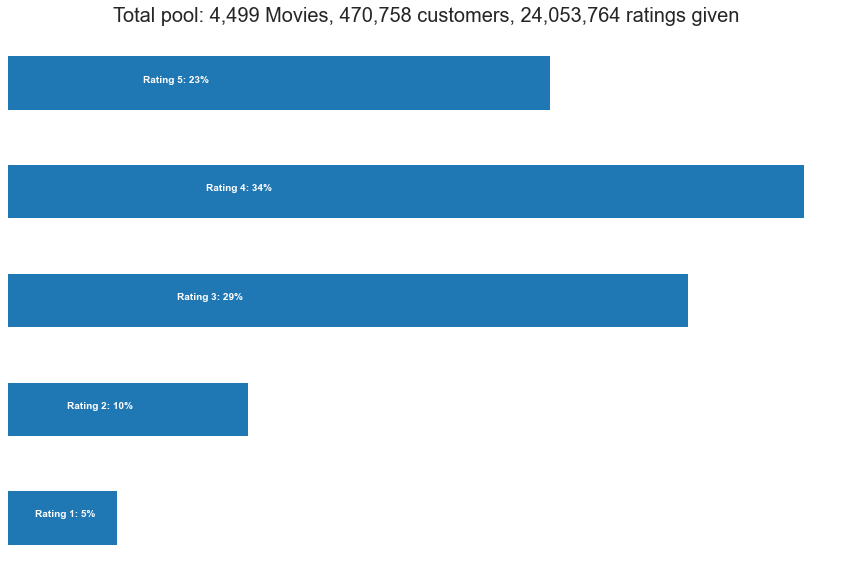

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

We see that the score tends to be relatively positive (> 3). This may be because unhappy customers tend to just leave instead of making an effort to rate. We can keep this in mind that low-rating movies mean they’re generally really bad.

### Data Preparation
The Movie ID column is a mess. We’re going to improve this by first creating a NumPy array with the correct length, then adding the entire array as a column in the main dataframe:

In [8]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


C:\Users\SHREE\AppData\Local\Temp/ipykernel_5716/1755511678.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)
C:\Users\SHREE\AppData\Local\Temp/ipykernel_5716/1755511678.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


The dataset is super huge. Therefore, we need to reduce the data volume by improving data quality. We can use these two approaches:

1) Delete the movie with too many reviews (they are relatively unpopular)

2) Remove the customer who gives too less notice (he is relatively less active)

In [9]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Movie minimum times of review: 1799.0
Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


### Netflix Recommendation Algorithm
Now let’s build the Netflix recommendation system:

In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_title = pd.read_csv('E:/Netflix Recommendation System with Python/movie_titles.csv', encoding = "ISO-8859-1", error_bad_lines=False, header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))
   
recommend("What the #$*! Do We Know!?", 0)

C:\Users\SHREE\AppData\Local\Temp/ipykernel_5716/2749552420.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_title = pd.read_csv('E:/Netflix Recommendation System with Python/movie_titles.csv', encoding = "ISO-8859-1", error_bad_lines=False, header = None, names = ['Movie_Id', 'Year', 'Name'])
b'Skipping line 72: expected 3 fields, saw 4\nSkipping line 264: expected 3 fields, saw 5\nSkipping line 350: expected 3 fields, saw 4\nSkipping line 366: expected 3 fields, saw 4\nSkipping line 394: expected 3 fields, saw 4\nSkipping line 466: expected 3 fields, saw 4\nSkipping line 582: expected 3 fields, saw 4\nSkipping line 600: expected 3 fields, saw 4\nSkipping line 670: expected 3 fields, saw 4\nSkipping line 672: expected 3 fields, saw 4\nSkipping line 729: expected 3 fields, saw 4\nSkipping line 776: expected 3 fields, saw 4\nSkipping line 827: expected 3 fields, saw 4\nSkipping line 834:

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                     Name  count     mean
 1.000000               What the #$*! Do We Know!?  14910 3.189805
 0.505500                                Inu-Yasha   1883 4.554434
 0.452807 Captain Pantoja and the Special Services   1801 3.417546
 0.442354                Without a Trace: Season 1   2124 3.980226
 0.384179                     Yu-Gi-Oh!: The Movie   3173 3.331547
 0.383959                                 Scorched   2430 2.894239
 0.381173  All Creatures Great and Small: Series 1   2327 3.938118
 0.381112          As Time Goes By: Series 1 and 2   2249 4.164073
 0.373018                         Cowboys & Angels   2368 3.589527
 0.371981                           Biggie & Tupac   1866 3.019293
